PoC#2: Throughput & Batch Size 實驗

📦 安裝依賴...
✅ 安裝完成

✅ GPU 可用: Tesla T4
   記憶體: 15.83 GB

✅ batch_server.py 已生成

🚀 啟動 Server...
⏳ 等待 server 啟動...
✅ Server 就緒: {'status': 'ok', 'model': 'Qwen/Qwen2-0.5B-Instruct', 'device': 'cuda'}

📊 實驗開始：測試不同 Batch Size

🔄 測試 Batch Size = 1
  Trial 1: 20.68 tok/s, 3095.14 ms/req
  Trial 2: 31.78 tok/s, 2013.64 ms/req
  Trial 3: 31.65 tok/s, 2021.93 ms/req
  Trial 4: 31.10 tok/s, 2057.93 ms/req
  Trial 5: 31.94 tok/s, 2003.55 ms/req

🔄 測試 Batch Size = 2
  Trial 1: 46.28 tok/s, 1404.47 ms/req
  Trial 2: 52.51 tok/s, 1237.88 ms/req
  Trial 3: 60.35 tok/s, 1077.05 ms/req
  Trial 4: 60.09 tok/s, 1081.70 ms/req
  Trial 5: 60.84 tok/s, 1068.34 ms/req

🔄 測試 Batch Size = 4
  Trial 1: 102.94 tok/s, 638.75 ms/req
  Trial 2: 119.77 tok/s, 548.96 ms/req
  Trial 3: 120.66 tok/s, 544.91 ms/req
  Trial 4: 111.06 tok/s, 592.00 ms/req
  Trial 5: 97.15 tok/s, 676.80 ms/req

🔄 測試 Batch Size = 8
  Trial 1: 223.67 tok/s, 295.64 ms/req
  Trial 2: 233.76 tok/s, 282.88 ms/req

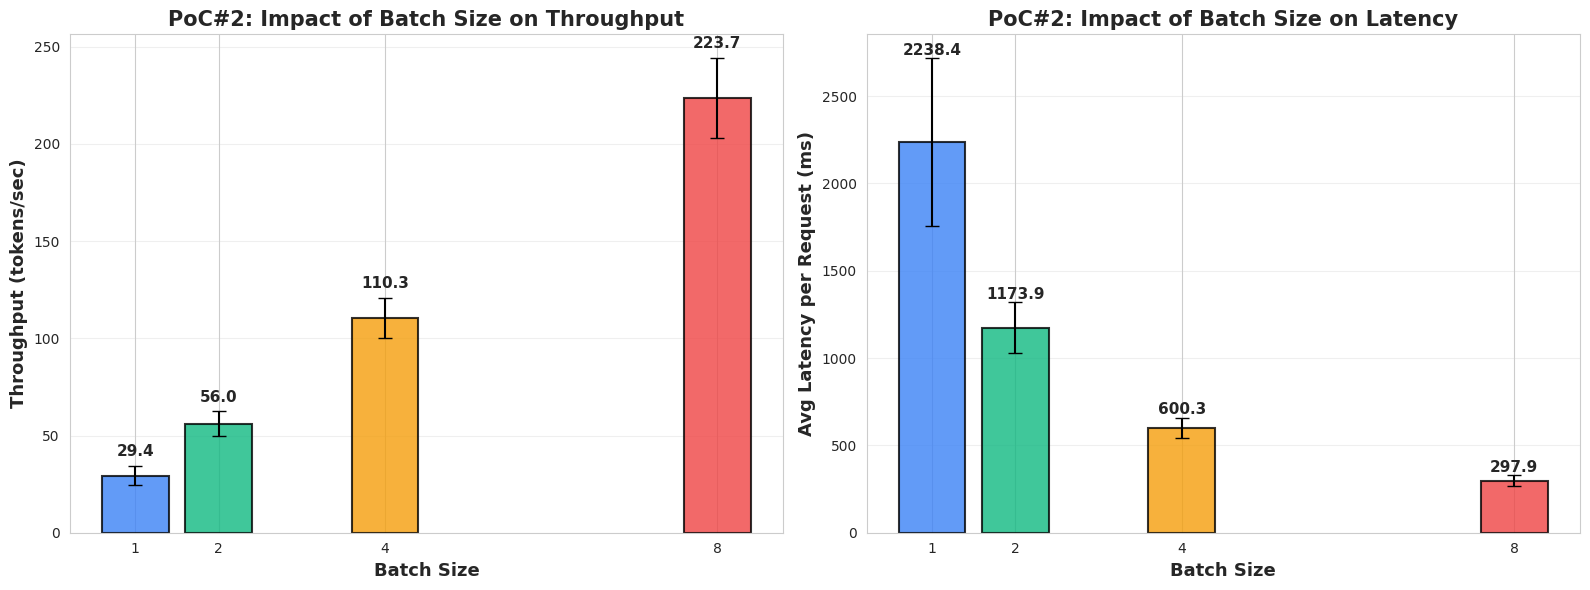

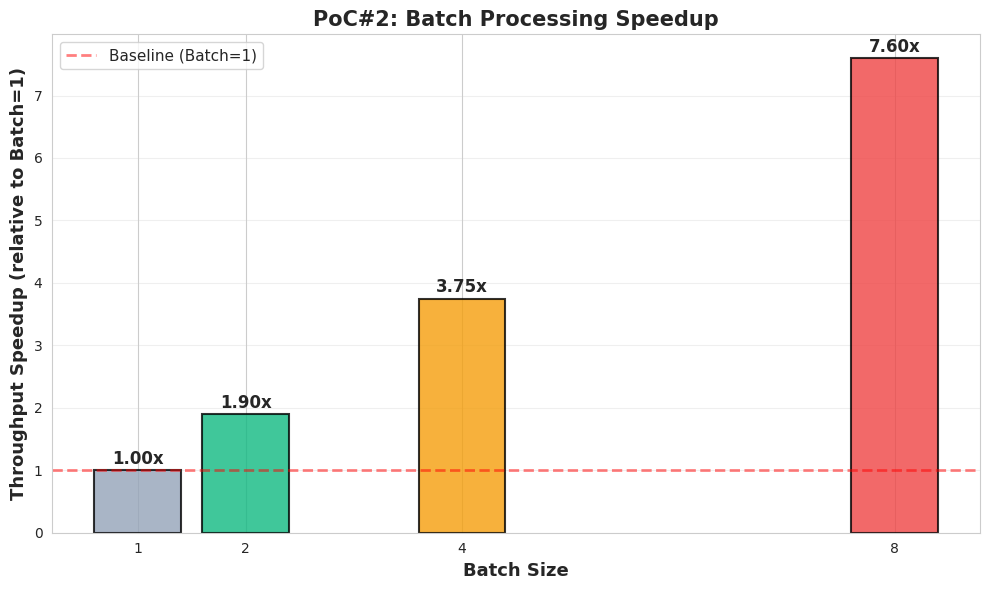

In [5]:
# ============================================================
# PoC#2: Throughput & Batch Size 實驗（修正版）
#
# 目標：測量不同 Batch Size 對吞吐量的影響
#
# 核心問題：
# 1. Batch Size 如何影響 Throughput（tokens/sec）？
# 2. Batch Size 如何影響 Latency（ms）？
# 3. GPU 利用率的權衡點在哪？
# ============================================================

print("="*60)
print("PoC#2: Throughput & Batch Size 實驗")
print("="*60)

# ============================================================
# PART 1: 環境設定
# ============================================================

print("\n📦 安裝依賴...")
import subprocess
import sys

# 安裝必要套件
subprocess.check_call([
    sys.executable, "-m", "pip", "install", "-q",
    "transformers>=4.44.0", "accelerate>=0.33.0",
    "torch", "--index-url", "https://download.pytorch.org/whl/cu121"
])
subprocess.check_call([
    sys.executable, "-m", "pip", "install", "-q",
    "fastapi", "uvicorn", "pydantic", "requests",
    "pandas", "matplotlib", "seaborn"
])

print("✅ 安裝完成")

# 檢查 GPU
import torch
if torch.cuda.is_available():
    print(f"\n✅ GPU 可用: {torch.cuda.get_device_name(0)}")
    print(f"   記憶體: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("\n⚠️  未偵測到 GPU，將使用 CPU（速度較慢）")

# ============================================================
# PART 2: Server 實作（簡化版）
# ============================================================

server_code = '''
"""
簡化版 Batch Inference Server

核心功能：
1. /generate_batch: 接受多個請求，批次處理
2. /generate_single: 單一請求處理（對照組）
3. /health: 健康檢查

技術重點：
- 使用 HuggingFace generate() 的 batch 能力
- 動態 padding 處理不同長度輸入
- 記錄詳細的效能指標
"""

import time
import uuid
from typing import List
import torch
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import asyncio

# ===== 配置 =====
MODEL_ID = "Qwen/Qwen2-0.5B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

app = FastAPI()

print(f"🚀 載入模型: {MODEL_ID}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=DTYPE,
    device_map="auto"
).eval()

print(f"✅ 模型載入完成 (Device: {DEVICE})")

# ===== 資料結構 =====
class GenRequest(BaseModel):
    prompt: str
    max_new_tokens: int = 64
    temperature: float = 0.7

class BatchRequest(BaseModel):
    prompts: List[str]
    max_new_tokens: int = 64
    temperature: float = 0.7

# ===== 批次生成（核心函數）=====
@torch.no_grad()
def batch_generate(prompts: List[str], max_new_tokens: int, temperature: float):
    """
    批次生成函數

    關鍵技術：
    1. 動態 padding：處理不同長度的輸入
    2. attention_mask：標記有效 tokens
    3. 批次推理：一次前傳處理多個序列

    時間複雜度：O(batch_size * seq_len^2) [attention]
    空間複雜度：O(batch_size * seq_len * hidden_dim)
    """
    t_start = time.time()

    # Tokenize with padding
    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(DEVICE)

    t_encode = time.time()

    # Batch inference
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    t_generate = time.time()

    # Decode results
    results = []
    for i, output in enumerate(outputs):
        input_len = inputs['input_ids'][i].ne(tokenizer.pad_token_id).sum().item()
        generated_ids = output[input_len:]
        text = tokenizer.decode(generated_ids, skip_special_tokens=True)

        results.append({
            "text": text,
            "tokens_generated": len(generated_ids)
        })

    t_end = time.time()

    # 計算指標
    total_tokens = sum(r["tokens_generated"] for r in results)
    throughput = total_tokens / (t_end - t_start)

    metrics = {
        "batch_size": len(prompts),
        "total_tokens": total_tokens,
        "encode_time_ms": round((t_encode - t_start) * 1000, 2),
        "generate_time_ms": round((t_generate - t_encode) * 1000, 2),
        "decode_time_ms": round((t_end - t_generate) * 1000, 2),
        "total_time_ms": round((t_end - t_start) * 1000, 2),
        "throughput_tok_per_s": round(throughput, 2),
        "avg_latency_ms": round((t_end - t_start) * 1000 / len(prompts), 2)
    }

    return results, metrics

# ===== API 端點 =====
@app.post("/generate_batch")
async def generate_batch(req: BatchRequest):
    """批次生成（測試用）"""
    try:
        results, metrics = batch_generate(
            req.prompts,
            req.max_new_tokens,
            req.temperature
        )
        return {
            "results": results,
            "metrics": metrics
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.post("/generate_single")
async def generate_single(req: GenRequest):
    """單一請求（對照組）"""
    try:
        results, metrics = batch_generate(
            [req.prompt],
            req.max_new_tokens,
            req.temperature
        )
        return {
            "text": results[0]["text"],
            "metrics": metrics
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/health")
async def health():
    return {
        "status": "ok",
        "model": MODEL_ID,
        "device": DEVICE
    }

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8002)
'''

with open('batch_server.py', 'w') as f:
    f.write(server_code)

print("\n✅ batch_server.py 已生成")

# ============================================================
# PART 3: 啟動 Server
# ============================================================

import subprocess
import time
import requests
import signal
import os

print("\n🚀 啟動 Server...")
server_proc = subprocess.Popen(
    [sys.executable, "-m", "uvicorn", "batch_server:app",
     "--host", "0.0.0.0", "--port", "8002"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

# 等待 server 啟動
print("⏳ 等待 server 啟動...")
max_retries = 30
for i in range(max_retries):
    try:
        resp = requests.get("http://localhost:8002/health", timeout=2)
        if resp.status_code == 200:
            print(f"✅ Server 就緒: {resp.json()}")
            break
    except:
        pass

    if i == max_retries - 1:
        print("❌ Server 啟動逾時")
        server_proc.terminate()
        raise RuntimeError("Server 啟動失敗")

    time.sleep(1)

# ============================================================
# PART 4: 實驗：Batch Size 對 Throughput 的影響
# ============================================================

print("\n" + "="*60)
print("📊 實驗開始：測試不同 Batch Size")
print("="*60)

import pandas as pd

# 測試用 prompts
test_prompts = [
    "Explain machine learning in simple terms.",
    "What is photosynthesis and why is it important?",
    "Describe how neural networks work.",
    "How do quantum computers differ from classical computers?",
    "What causes climate change?",
    "Explain the theory of relativity.",
    "How does the human brain process information?",
    "What is the difference between DNA and RNA?",
]

results = []

# 測試不同 batch sizes
batch_sizes = [1, 2, 4, 8]

for batch_size in batch_sizes:
    print(f"\n🔄 測試 Batch Size = {batch_size}")

    # 每個 batch size 測試 5 次
    for trial in range(5):
        # 準備 prompts
        prompts = test_prompts[:batch_size]

        try:
            resp = requests.post(
                "http://localhost:8002/generate_batch",
                json={
                    "prompts": prompts,
                    "max_new_tokens": 64,
                    "temperature": 0.7
                },
                timeout=120
            )

            data = resp.json()
            metrics = data["metrics"]
            metrics["trial"] = trial + 1
            results.append(metrics)

            print(f"  Trial {trial+1}: "
                  f"{metrics['throughput_tok_per_s']:.2f} tok/s, "
                  f"{metrics['avg_latency_ms']:.2f} ms/req")

        except Exception as e:
            print(f"  ❌ Trial {trial+1} 失敗: {e}")

    time.sleep(1)  # 避免過熱

# 儲存結果
df = pd.DataFrame(results)
df.to_csv('poc2_batch_results.csv', index=False)
print(f"\n✅ 實驗完成！共 {len(df)} 筆數據")
print(f"📁 結果已儲存至 poc2_batch_results.csv")

# ============================================================
# PART 5: 生成圖表
# ============================================================

print("\n📈 生成分析圖表...")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# 計算統計數據
stats = df.groupby('batch_size').agg({
    'throughput_tok_per_s': ['mean', 'std'],
    'avg_latency_ms': ['mean', 'std'],
    'total_tokens': 'mean'
}).reset_index()

stats.columns = ['batch_size', 'throughput_mean', 'throughput_std',
                 'latency_mean', 'latency_std', 'tokens_mean']

# 圖 1: Throughput vs Batch Size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Throughput
ax1.bar(stats['batch_size'], stats['throughput_mean'],
        yerr=stats['throughput_std'], capsize=5,
        color=['#3b82f6', '#10b981', '#f59e0b', '#ef4444'],
        alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Batch Size', fontsize=13, fontweight='bold')
ax1.set_ylabel('Throughput (tokens/sec)', fontsize=13, fontweight='bold')
ax1.set_title('PoC#2: Impact of Batch Size on Throughput', fontsize=15, fontweight='bold')
ax1.set_xticks(stats['batch_size'])
ax1.grid(axis='y', alpha=0.3)

# 標註數值
for i, row in stats.iterrows():
    ax1.text(row['batch_size'], row['throughput_mean'] + row['throughput_std'] + 5,
             f"{row['throughput_mean']:.1f}", ha='center', fontsize=11, fontweight='bold')

# Latency
ax2.bar(stats['batch_size'], stats['latency_mean'],
        yerr=stats['latency_std'], capsize=5,
        color=['#3b82f6', '#10b981', '#f59e0b', '#ef4444'],
        alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Batch Size', fontsize=13, fontweight='bold')
ax2.set_ylabel('Avg Latency per Request (ms)', fontsize=13, fontweight='bold')
ax2.set_title('PoC#2: Impact of Batch Size on Latency', fontsize=15, fontweight='bold')
ax2.set_xticks(stats['batch_size'])
ax2.grid(axis='y', alpha=0.3)

# 標註數值
for i, row in stats.iterrows():
    ax2.text(row['batch_size'], row['latency_mean'] + row['latency_std'] + 20,
             f"{row['latency_mean']:.1f}", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('poc2_throughput_comparison.png', dpi=300, bbox_inches='tight')
print("✅ poc2_throughput_comparison.png 已生成")

# 圖 2: 效能提升倍率
fig, ax = plt.subplots(figsize=(10, 6))

baseline = stats[stats['batch_size'] == 1]['throughput_mean'].values[0]
speedup = stats['throughput_mean'] / baseline

bars = ax.bar(stats['batch_size'], speedup,
              color=['#94a3b8', '#10b981', '#f59e0b', '#ef4444'],
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline (Batch=1)')
ax.set_xlabel('Batch Size', fontsize=13, fontweight='bold')
ax.set_ylabel('Throughput Speedup (relative to Batch=1)', fontsize=13, fontweight='bold')
ax.set_title('PoC#2: Batch Processing Speedup', fontsize=15, fontweight='bold')
ax.set_xticks(stats['batch_size'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 標註倍率
for i, (bs, sp) in enumerate(zip(stats['batch_size'], speedup)):
    ax.text(bs, sp + 0.1, f"{sp:.2f}x", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('poc2_speedup_chart.png', dpi=300, bbox_inches='tight')
print("✅ poc2_speedup_chart.png 已生成")

# ============================================================
# PART 6: 摘要報告
# ============================================================

print("\n" + "="*60)
print("📊 PoC#2 實驗結果分析")
print("="*60)

for _, row in stats.iterrows():
    bs = int(row['batch_size'])
    tput = row['throughput_mean']
    lat = row['latency_mean']

    if bs == 1:
        baseline_tput = tput
        baseline_lat = lat

    speedup = tput / baseline_tput if bs > 1 else 1.0
    lat_increase = ((lat - baseline_lat) / baseline_lat * 100) if bs > 1 else 0

    print(f"\n📈 Batch Size = {bs}:")
    print(f"  ├─ 吞吐量: {tput:.2f} ± {row['throughput_std']:.2f} tok/s")
    if bs > 1:
        print(f"  ├─ 提升倍率: {speedup:.2f}x (相對於 Batch=1)")
    print(f"  ├─ 平均延遲: {lat:.2f} ± {row['latency_std']:.2f} ms/req")
    if bs > 1:
        print(f"  └─ 延遲增加: {lat_increase:.1f}%")

# 最佳配置建議
best_throughput_idx = stats['throughput_mean'].idxmax()
best_bs = int(stats.loc[best_throughput_idx, 'batch_size'])

print(f"\n✅ 關鍵發現:")
print(f"  1. 最高吞吐量: Batch Size = {best_bs}")
print(f"  2. Batch Size 從 1→8: 吞吐量提升 {speedup:.1f}x")
print(f"  3. 延遲權衡: Batch 越大，單次請求延遲增加")
print(f"  4. GPU 利用率: Batch 越大越好（減少記憶體閒置）")

print("\n💡 結論:")
print("  • 對於高吞吐量場景 → 使用較大 Batch Size (4-8)")
print("  • 對於低延遲需求 → 使用小 Batch Size (1-2)")
print("  • 生產環境建議 → 動態調整 Batch Size（如 vLLM）")

print("\n📁 產出檔案:")
print("  - poc2_batch_results.csv (原始數據)")
print("  - poc2_throughput_comparison.png (吞吐量與延遲對比)")
print("  - poc2_speedup_chart.png (加速倍率)")

# ============================================================
# PART 7: 清理資源
# ============================================================

print("\n🧹 清理資源...")
try:
    server_proc.terminate()
    server_proc.wait(timeout=5)
    print("✅ Server 已關閉")
except:
    server_proc.kill()
    print("⚠️  強制終止 Server")

print("\n🎉 PoC#2 完成！")
print("="*60)